In [34]:
import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lp
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
%matplotlib inline

In [35]:
ref = pd.read_csv(
    "../data - AirBnb/listings.csv.gz", compression='gzip', on_bad_lines='skip')
df = gpd.read_file(
    "../data - AirBnb/neighbourhoods.geojson"
)




ref['price'] = ref['price'].str.replace('$', '').str.replace(',', '').astype(float)
ref = ref[ref['price'] < 1000]

median = ref['price'].median()

ref['neighbourhood'] = ref['neighbourhood_cleansed']

/home/christoph/miniconda3/envs/dop-ex2/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

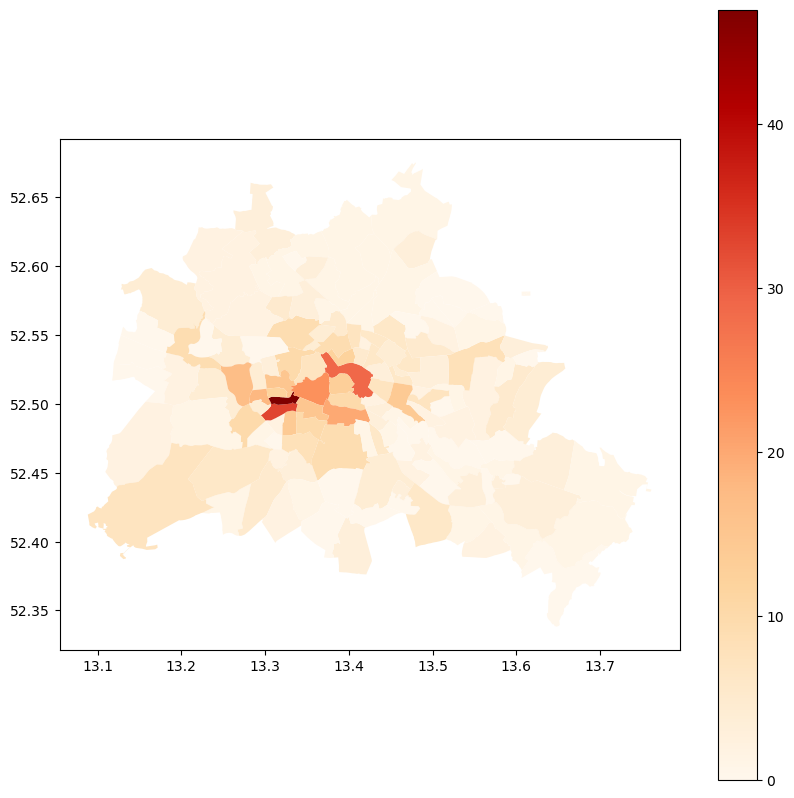

In [36]:
hotels = pd.read_csv('../data - Tourpedia/berlin-accommodation_v2.csv', sep = ';')

# assign hotels to neighbourhoods based on coordinates
geometry = [Point(xy) for xy in zip(hotels['lng'], hotels['lat'])]
crs = {'init': 'epsg:4326'}
geo_df = GeoDataFrame(hotels, crs=crs, geometry=geometry)
df['count'] = 0

for idx, poly in df.iterrows():
    count = geo_df.within(poly['geometry']).sum()
    df.at[idx, 'count'] = count

df.plot(column='count', cmap='OrRd', legend=True, figsize=(10, 10))

In [37]:
df.set_index('neighbourhood', inplace=True)

In [38]:
df['price'] = df['count']

<Axes: >

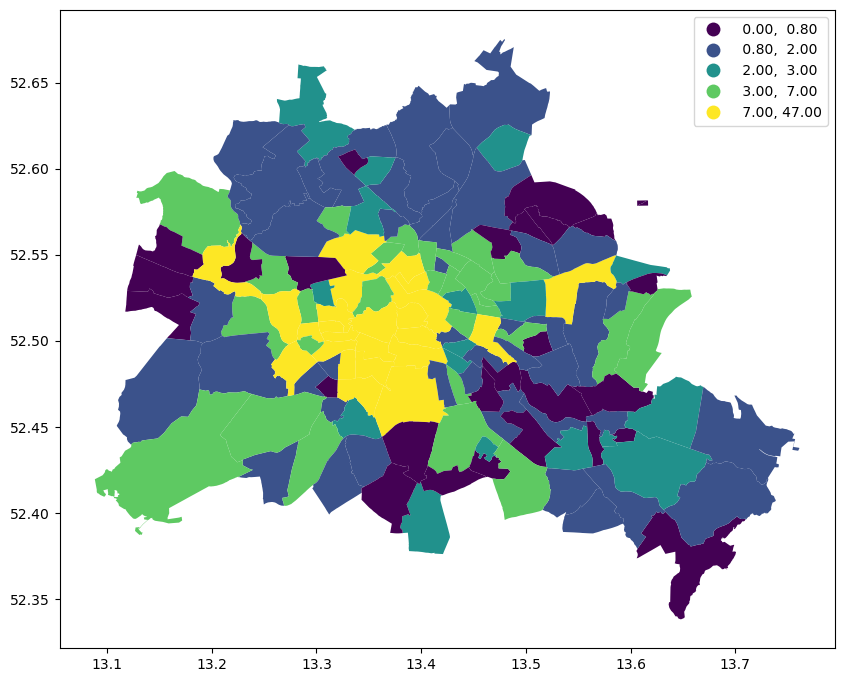

In [39]:
df.plot(column='price', legend=True, figsize=(10, 10), scheme='quantiles')

In [40]:
# convert multi-polygons to polygons. Luckily, for this dataset, all of the multi polygons contain just one polygon
df['geometry'] = df['geometry'].apply(lambda x: x.geoms[0])

wq =  lp.weights.Queen.from_dataframe(df)
wq.transform = 'r'


/home/christoph/miniconda3/envs/dop-ex2/lib/python3.12/site-packages/libpysal/weights/_contW_lists.py:23: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if shape.type.lower() == "polygon":
/home/christoph/miniconda3/envs/dop-ex2/lib/python3.12/site-packages/libpysal/weights/_contW_lists.py:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif shape.type.lower() == "linestring":
/home/christoph/miniconda3/envs/dop-ex2/lib/python3.12/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [41]:
y = df['price']
ylag = lp.weights.lag_spatial(wq, y)


In [42]:
import mapclassify as mc
ylagq5 = mc.Quantiles(ylag, k=5)

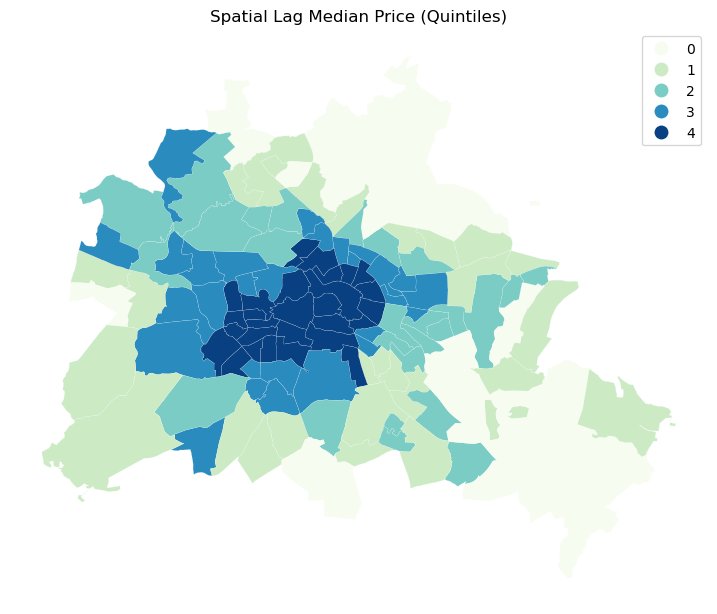

In [43]:
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=ylagq5.yb).plot(column='cl', categorical=True,
        k=5, cmap='GnBu', linewidth=0.1, ax=ax,
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag Median Price (Quintiles)")

plt.show()


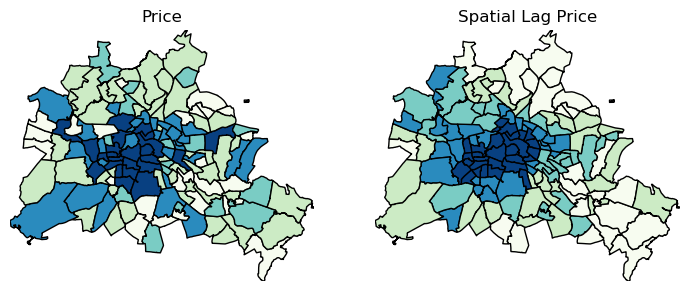

In [44]:
df['lag_median_pri'] = ylag
f,ax = plt.subplots(1,2,figsize=(2.16*4,4))
df.plot(column='price', ax=ax[0], edgecolor='k',
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Price")
df.plot(column='lag_median_pri', ax=ax[1], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Price")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [45]:
yb = y > y.median()
sum(yb)

69

In [46]:
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb] 
df['yb'] = yb

<Axes: >

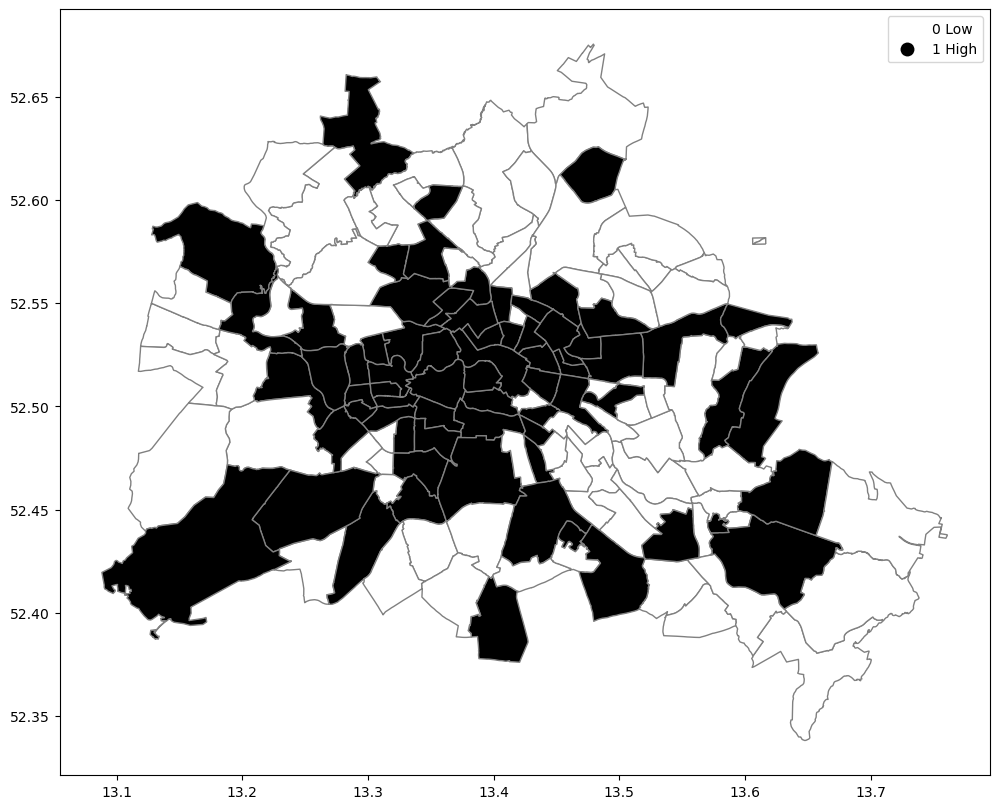

In [47]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)


In [48]:
np.random.seed(12345)
import esda


In [49]:
wq.transform = 'r'
lag_price = lp.weights.lag_spatial(wq, df['price'])

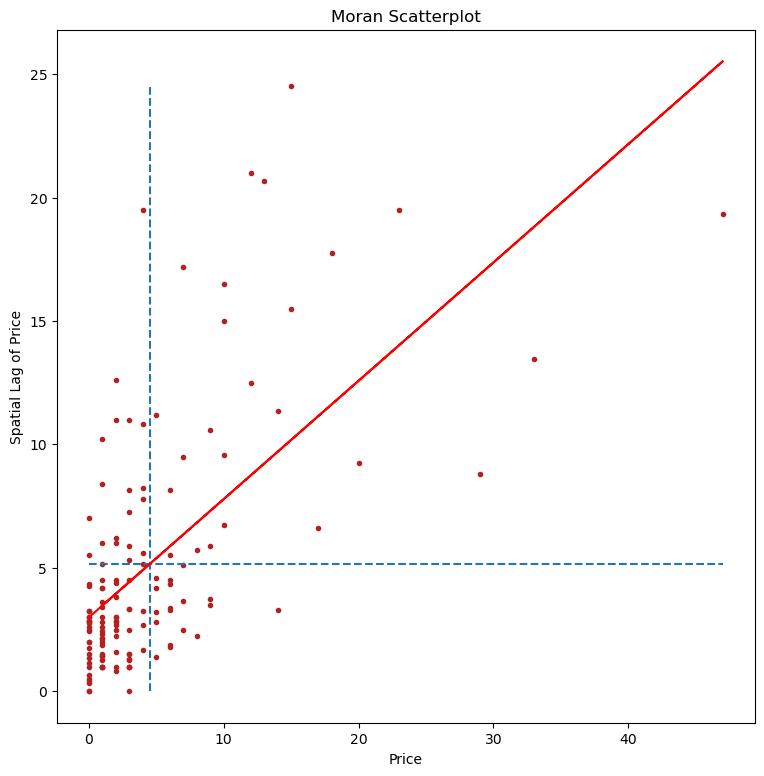

In [50]:
price = df['price']
b, a = np.polyfit(price, lag_price, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(price, lag_price, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(price.mean(), lag_price.min(), lag_price.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(lag_price.mean(), price.min(), price.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(price, a + b*price, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Price')
plt.xlabel('Price')
plt.show()


In [51]:
li = esda.moran.Moran_Local(y, wq)


In [52]:
sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4


In [53]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]


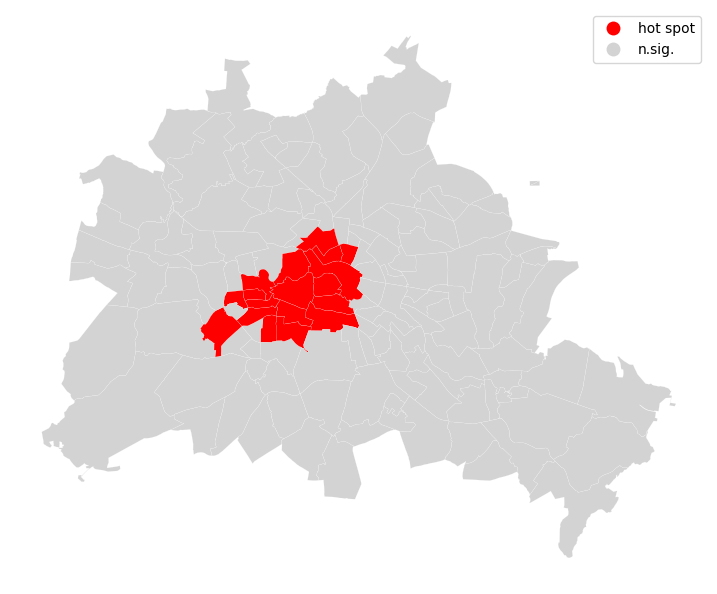

In [54]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()


In [55]:
spots = ['n.sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]


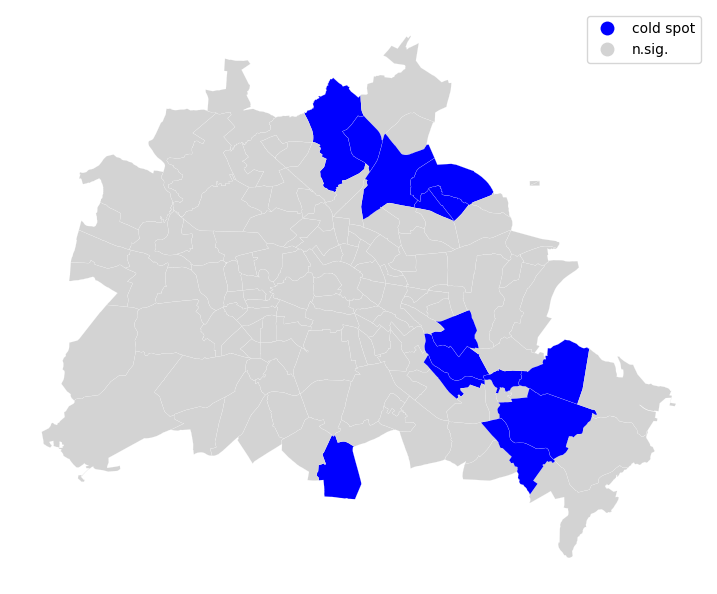

In [56]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()